<a href="https://colab.research.google.com/github/lee-j-j/LJJ/blob/main/ex07_%EB%B2%A0%EC%8A%A4%ED%8A%B8%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5%EC%A4%91%EB%8B%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 손글씨 데이터셋을 이용한 다진 분류

- 데이터 다운로드

In [26]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

_ 손글씨 숫자 데이터셋
  - 훈련데이터 6만개, 테스트데이터 1만개
  - 각각의 데이터는 28x28 크기로 구성
  - 흑백 이미지 (0 ~ 255 값으로 구성)
  - 배경은 검정색, 글씨는 흰색으로 구성
    - 정보는 글씨에 담겨 있기 때문에 값이 큰 수(흰색)를 할당

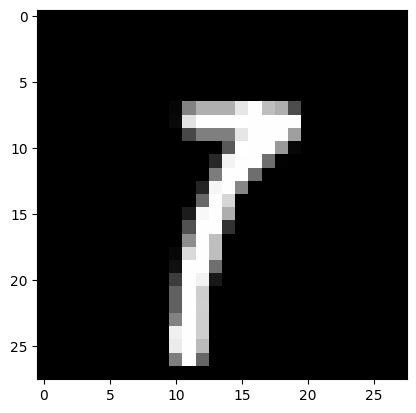

7


In [27]:
# 데이터 하나 확인
import matplotlib.pyplot as plt

digit = X_train[644]
label = y_train[644]

plt.imshow(digit, cmap = "gray")
plt.show()

print(label)

- 데이터 전처리
  - 2차원 데이터를 1차원 데이터로 변환 (DNN층의 입력이 1차원이므로)
  - 데이터 값의 범위를 0 ~ 255에서 0 ~ 1로 변환 (정규화 : Scaling) - 과적합이 줄어듦

In [28]:
from numpy import float32
# 2차원 → 1차원
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

# 스케일링
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

- y를 원핫인코딩
  - to_categorical() : 라벨인코딩이 숫자로 되어있는 경우에만 사용 가능
  - 숫자가 아닌 경우 pandas의 get_dummies로 원핫인코딩

In [29]:
from tensorflow.keras.utils import to_categorical

y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

y_train_en.shape, y_test.shape

((60000, 10), (10000,))

In [30]:
# 라벨값 확인
import pandas as pd

print(pd.Series(y_train).unique())
print(pd.Series(y_test).unique())

[5 0 4 1 9 2 3 6 7 8]
[7 2 1 0 4 9 5 6 3 8]


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential()

# 입력층
model1.add(Dense(units = 512, input_dim = 28*28, activation = "sigmoid")) # input_dim : 28*28 = X_train.shape[1]

# 은닉층
model1.add(Dense(units = 256, input_dim = 28*28, activation = "sigmoid"))

# 출력층
model1.add(Dense(units = 10, activation = "softmax")) # 원핫인코딩 → activation은 softmax  # units : 10 = y_train_en.shape[1]

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


- 컴파일

In [32]:
model1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# 베스트 모델 저장과 학습중단

- 베스트 모델 저장 : 가장 좋은 모델이 마지막 모델이 아닐 수도 있음 → 학습 중간에 가장 좋은 모델을 저장해야 함
  - ModelCheckpoint()

- 학습중단 (Early Stopping) : 학습이 더 이상 좋아지지 않는 경우에 반복을 중지
  - EarlyStopping()

In [33]:
%cd /content/drive/MyDrive/Colab Notebooks/사물지능A

/content/drive/MyDrive/Colab Notebooks/사물지능A


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# 모델을 저장하기 위한 폴더
model_dir = "./model/"

# 폴더가 없다면 생성
if not os.path.exists(model_dir) :
  os.mkdir(model_dir)

# 저장할 파일명 설정
# epoch:03d : epoch 값을 정수형(d) 세자리(03) 값으로 출력
# val_accuracy:,3f : val_accuracy 값을 실수형(f) 소수점 3째자리(.3)까지 출력
# 파일명 예시 : best_010_0.83_0.02.hdf5
file_path = model_dir + "best_{epoch:03d}_{accuracy:.3f}_{val_accuracy:3f}.hdf5"

# filepath : 저장할 파일명
# monitor : 베스트모델 판단 기준
# save_best_only : True이면 더 나은 모델만 저장, False이면 전부 다 저장
ms = ModelCheckpoint(filepath = file_path, monitor = "val_accuracy", save_best_only=True)

# monitor : 학습중단 기준 (베스트모델의 판단 기준과 동일하게 설정)
# patience : 더 나은 모델이 아니더라도 몇 epoch를 더 대기할 것인지 설정
es = EarlyStopping(monitor = "val_accuracy", patience=10)

- 학습

In [35]:
# batch_size : 한 번 학습할 때 사용할 데이터의 수
# validation_data : 검증 데이터 셋 설정
h1 = model1.fit(X_train, y_train_en, epochs = 10, batch_size = 100, validation_data=(X_test, y_test_en), callbacks = [ms, es])

Epoch 1/10
600/600 [==============================] - 10s 14ms/step - loss: 0.4594 - accuracy: 0.8738 - val_loss: 0.2363 - val_accuracy: 0.9291
Epoch 2/10
600/600 [==============================] - 10s 17ms/step - loss: 0.2036 - accuracy: 0.9397 - val_loss: 0.1626 - val_accuracy: 0.9508
Epoch 3/10
600/600 [==============================] - 9s 15ms/step - loss: 0.1447 - accuracy: 0.9562 - val_loss: 0.1273 - val_accuracy: 0.9614
Epoch 4/10
600/600 [==============================] - 9s 15ms/step - loss: 0.1081 - accuracy: 0.9679 - val_loss: 0.1048 - val_accuracy: 0.9684
Epoch 5/10
600/600 [==============================] - 10s 16ms/step - loss: 0.0819 - accuracy: 0.9758 - val_loss: 0.0907 - val_accuracy: 0.9708
Epoch 6/10
600/600 [==============================] - 8s 14ms/step - loss: 0.0642 - accuracy: 0.9807 - val_loss: 0.0864 - val_accuracy: 0.9743
Epoch 7/10
600/600 [==============================] - 10s 16ms/step - loss: 0.0506 - accuracy: 0.9845 - val_loss: 0.0750 - val_accuracy: 0.